#Results:

In [1]:
import pandas as pd
results_ = {'Approach': ['XGBoost','Fastai','Catboost','LightGBM'],
        'RSME': [0.435097,0.399569,0.2522909698,0.4238094066114889]
        }
df = pd.DataFrame(results_, columns = ['Approach', 'RSME'])
df= df.sort_values(by='RSME', ascending=True)
df.head(8)

,Approach,RSME
2,Catboost,0.252291
1,Fastai,0.399569
3,LightGBM,0.423809
0,XGBoost,0.435097


#**Fastai-Library:**

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import numpy as np
import pandas as pd
import datetime
from fastai import *
from fastai.tabular import *

# Data Preperation

preprocessing data

In [0]:
rheindata = pd.read_csv("/content/drive/My Drive/fastai/data_rhein_incl_km(1).csv")
rheindata = rheindata[["Kürzel","Date","year","month","day","Temp.(BAFU)","pH(BAFU)","Leitf. 25°C(BAFU)","Sauerstoff","Sauerstoffsätt.%","pH (EAWAG)","Leitf.20°C (EAWAG)","Alkalinität","Calcium","Magnesium","Nitrit","Nitrat","Ammonium","Kjeldahl-Stickstoff","Gesamt-Stickstoff","DRP","Gesamt-Phosphor","Chlorid","Kieselsäure","Sulfat","Natrium","Kalium","Eisen","Chem.Sauerstoffbedarf","TOC","DOC","Schwebstoffe","Chrom","Zink","Kupfer","Blei","Cadmium","Nickel","Quecksilber"]]
rheindata['DOC'].replace('', np.nan, inplace=True)
rheindata.dropna(subset=['DOC'], inplace=True)
procs = [FillMissing, Categorify, Normalize]

defining dependet, categorical and continuous variables


In [0]:
dep_var = 'DOC'
cat_names = ['Kürzel', 'Date' ,'year','month','day']
cont_names = ["Temp.(BAFU)","pH(BAFU)","Leitf. 25°C(BAFU)","Sauerstoff","Sauerstoffsätt.%","pH (EAWAG)","Leitf.20°C (EAWAG)","Alkalinität","Calcium","Magnesium","Nitrit","Nitrat","Ammonium","Kjeldahl-Stickstoff","Gesamt-Stickstoff","DRP","Gesamt-Phosphor","Chlorid","Kieselsäure","Sulfat","Natrium","Kalium","Eisen","Chem.Sauerstoffbedarf","Schwebstoffe","Chrom","Zink","Kupfer","Blei","Cadmium","Nickel","Quecksilber" ]

include datetimeindex

In [0]:
datum = rheindata["Date"]
list_datum = [datetime.datetime.strptime(str_,"%d.%m.%Y") for str_ in datum]
rheindata.head()

,Kürzel,Date,year,month,day,Temp.(BAFU),pH(BAFU),Leitf. 25°C(BAFU),Sauerstoff,Sauerstoffsätt.%,pH (EAWAG),Leitf.20°C (EAWAG),Alkalinität,Calcium,Magnesium,Nitrit,Nitrat,Ammonium,Kjeldahl-Stickstoff,Gesamt-Stickstoff,DRP,Gesamt-Phosphor,Chlorid,Kieselsäure,Sulfat,Natrium,Kalium,Eisen,Chem.Sauerstoffbedarf,TOC,DOC,Schwebstoffe,Chrom,Zink,Kupfer,Blei,Cadmium,Nickel,Quecksilber
0,RE,26.05.1975,1975,5,26,NaN,NaN,NaN,NaN,NaN,8.0,270.0,2.32,48.0960,6.3232,0.02,0.4,0.05,NaN,NaN,0.04,0.09,4.4,3.0,29.0,4.8,1.4,0.04,NaN,2.6,1.4,11.0,0.5,5.0,0.5,0.5,0.1,NaN,NaN
1,RE,02.06.1975,1975,6,2,13.7,NaN,NaN,NaN,NaN,8.2,280.0,2.32,50.5008,5.8368,0.03,0.7,0.03,NaN,NaN,0.07,0.18,5.6,3.0,30.0,4.7,1.3,0.09,NaN,2.2,1.8,6.5,0.5,10.0,2.0,1.0,0.1,NaN,NaN
2,RE,09.06.1975,1975,6,9,13.4,NaN,NaN,NaN,NaN,8.1,290.0,2.60,51.3024,5.8368,0.03,0.7,0.01,NaN,NaN,0.03,0.18,6.0,4.0,29.0,4.8,1.3,0.06,NaN,2.2,1.8,6.2,2.0,10.0,1.0,4.0,0.1,NaN,NaN
3,RE,16.06.1975,1975,6,16,14.9,NaN,NaN,NaN,NaN,8.2,280.0,2.44,48.8976,7.2960,0.02,0.7,0.06,NaN,NaN,0.04,0.18,5.4,4.0,29.0,4.9,1.3,0.07,NaN,2.4,1.8,1.2,0.5,10.0,1.0,1.0,0.1,NaN,NaN
4,RE,23.06.1975,1975,6,23,14.4,NaN,NaN,NaN,NaN,7.9,270.0,2.48,53.7072,5.8368,0.02,0.8,0.02,NaN,NaN,0.04,0.15,5.4,4.0,29.0,4.6,1.5,0.16,NaN,3.4,1.9,22.0,1.0,10.0,2.0,2.0,0.1,NaN,NaN


In [0]:
rheindata.dtypes

Kürzel                    object
Date                      object
year                       int64
month                      int64
day                        int64
Temp.(BAFU)              float64
pH(BAFU)                 float64
Leitf. 25°C(BAFU)        float64
Sauerstoff               float64
Sauerstoffsätt.%         float64
pH (EAWAG)               float64
Leitf.20°C (EAWAG)       float64
Alkalinität              float64
Calcium                  float64
Magnesium                float64
Nitrit                   float64
Nitrat                   float64
Ammonium                 float64
Kjeldahl-Stickstoff      float64
Gesamt-Stickstoff        float64
DRP                      float64
Gesamt-Phosphor          float64
Chlorid                  float64
Kieselsäure              float64
Sulfat                   float64
Natrium                  float64
Kalium                   float64
Eisen                    float64
Chem.Sauerstoffbedarf    float64
TOC                      float64
DOC       

defining the test set

In [0]:
test = TabularList.from_df(rheindata.iloc[2600:2900].copy(), path= '/content/drive/My Drive/fastai/data_rhein_incl_km(1).csv', cat_names = cat_names, cont_names = cont_names)

create a tabular list from the created dataframe splitted by the indexes

In [0]:
data = (TabularList.from_df(rheindata, cat_names = cat_names, cont_names = cont_names, procs = procs)
        .split_by_idx(list(range(2600, 2900)))
        .label_from_df(cols=dep_var)
        .add_test(test, label=0)
        .databunch())

# Model

In [0]:
max_log_y = math.log(np.max(rheindata['DOC'])*1,2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
                        y_range=y_range, metrics=exp_rmspe)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(1582, 99)
    (2): Embedding(45, 13)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
    (15): Embedding(3, 3)
    (16): Embedding(3, 3)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
    (19): Embedding(3, 3)
    (20): Embedding(3, 3)
    (21): Embedding(3, 3)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
    (24): Embedding(3, 3)
    (25): Embedding(3, 3)
    (26): Embedding(3, 3)
    (27): Embedding(3, 3)
    (28): Embedding(3, 3)
    (29): Embedding(3, 3)
    (30): Embedding(3, 3)
    (31): Embedding(3, 3)
    (32): Embedding(3, 3)
    (33): Embedding(3, 3)
    (34): Embedding(3, 3)
    (35): Embedding(3, 3)
  )
  (emb_drop): Dropout(p

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


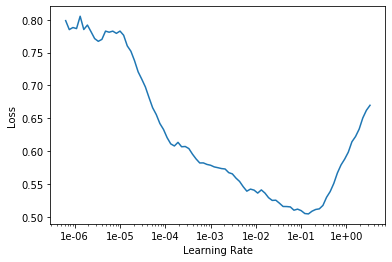

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, 5e-5,wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.496854,0.165247,0.323056,00:01
1,0.370354,0.274982,0.384966,00:01
2,0.316593,0.213474,0.387213,00:01
3,0.287550,0.219880,0.402835,00:01


In [0]:
learn.save('model.1')

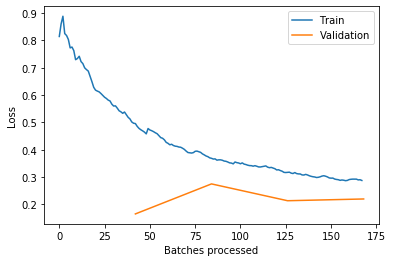

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.load('model.1')

Learner(data=TabularDataBunch;

Train: LabelList (2743 items)
x: TabularList
Kürzel RE; Date 26.05.1975; year 1975; month 5; day 26; Temp.(BAFU)_na True; pH(BAFU)_na True; Leitf. 25°C(BAFU)_na True; Sauerstoff_na True; Sauerstoffsätt.%_na True; pH (EAWAG)_na False; Leitf.20°C (EAWAG)_na False; Alkalinität_na False; Calcium_na False; Magnesium_na False; Nitrit_na False; Nitrat_na False; Ammonium_na False; Kjeldahl-Stickstoff_na True; Gesamt-Stickstoff_na True; DRP_na False; Gesamt-Phosphor_na False; Kieselsäure_na False; Sulfat_na False; Natrium_na False; Kalium_na False; Eisen_na False; Chem.Sauerstoffbedarf_na True; Schwebstoffe_na False; Chrom_na False; Zink_na False; Kupfer_na False; Blei_na False; Cadmium_na False; Nickel_na True; Quecksilber_na True; Temp.(BAFU) -0.1684; pH(BAFU) 0.0883; Leitf. 25°C(BAFU) 0.0884; Sauerstoff -0.0183; Sauerstoffsätt.% -0.0916; pH (EAWAG) -0.1626; Leitf.20°C (EAWAG) -0.4921; Alkalinität -0.1156; Calcium -0.0725; Magnesium -1.4810; Nitrit 1.5137; Nitr

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


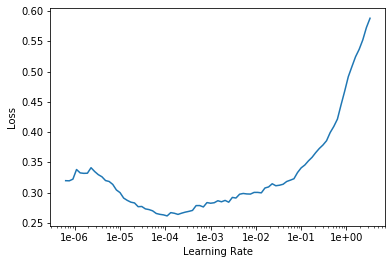

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, 1e-5)ch

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.270676,0.209402,0.391125,00:01
1,0.270385,0.207186,0.390334,00:01
2,0.276195,0.224218,0.399569,00:01


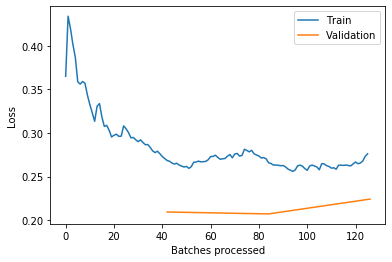

In [0]:
learn.recorder.plot_losses()